# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

# Load Data for Modelling

In [ ]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .query("Churn == 1")  # subset churned customer
      .drop(labels=['customerID','TotalCharges','Churn'],axis=1)  
                    # variables we will not need for this project
                    # we will not need Churn, since it is has only 1
  )

df.info()

# Regressor: Sklearn

* In the ML Pipeline, we are using the raw data, therefore we need to create the pipeline with data cleaninig and feature engineering steps
  * This pipeline will be used in the Train Set, Test Set and Live Data

### ML pipeline for Data Cleaning and Feature Engineering

Load Estimators

In [ ]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

 Pipeline for Data Cleaning and Feat Eng

In [ ]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'gender', 'Partner', 'Dependents', 'PhoneService',
                                                               'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup','DeviceProtection', 'TechSupport', 
                                                               'StreamingTV', 'StreamingMovies','Contract', 
                                                               'PaperlessBilling', 'PaymentMethod']
                                                  )
      ),      
       

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman",
                                                           threshold=0.6,selection_method="variance")
      ),
       
    ]
  )

  return pipeline_base

## ML Pipeline for Modelling and Hyperparameter Optimization

* Pipeline Optmization: Add Feature Scaling, Feature Selection and Model

In [ ]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["feat_selection", SelectFromModel(model)])
  pipe.steps.append(["model", model])
  
  return pipe

Custom Class for hyperparameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

Quick recap in our raw dataset

In [ ]:
print(df.shape)
df.head(3)

Split Train and Test Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['tenure'],axis=1),
                                    df['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

## Target Distribution Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

def Target_DistributionAndStats(y_train,y_test):

  figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,3))
  sns.histplot(x=y_train, kde=True,ax=ax[0]).set(title='y train')
  sns.histplot(x=y_test, kde=True,ax=ax[1]).set(title='y test')
  plt.show()

  print("\n* Train set - target descriptive stats: \n", y_train.describe().to_frame().round(3))
  print(f"\n* Train set skewness: {y_train.skew().round(3)}, and kurtosis: {y_train.kurt().round(3)} \n\n")

In [ ]:
Target_DistributionAndStats(y_train, y_test)

Target Transformation

In [ ]:
import sklearn.preprocessing
target_transformer = sklearn.preprocessing.PowerTransformer(method='box-cox',standardize=True)

y_train = target_transformer.fit_transform(y_train.to_frame())
y_train = pd.Series(y_train.reshape(-1), name='tenure')

y_test = target_transformer.transform(y_test.to_frame())
y_test = pd.Series(y_test.reshape(-1), name='tenure')

Target_DistributionAndStats(y_train,y_test)

## Grid Search CV - Sklearn

### Use standard hyper parameters to find most suitable model

Define models for quick search

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a hyperparameter optmization search 

In [ ]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor, based on search

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Assess feature importance

In [ ]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

## Evaluate Regressor on Train and Test Sets

Custom Functions

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

  print("\n")
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
  sns.histplot(x=pred_train-y_train, kde=True, ax=axes[0])
  axes[0].set_title("Residuals Train Set")
  sns.histplot(x=pred_test-y_test, kde=True, ax=axes[1])
  axes[1].set_title("Residuals Test Set")

Evaluate Performance

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline,
                            alpha_scatter=0.5)

# Regressor add PCA() in the pipeline: Sklearn

## Rewrite ML Pipeline for Modelling: add PCA step

* It will change only the PipelineOptimization() function

In [ ]:
### PCA
from sklearn.decomposition import PCA

def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["PCA",PCA(n_components=3, random_state=0)])   #### PCA replace Feature Selection
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["model", model])
  
  return pipe

## Grid Search CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optmization search 

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor, based on search

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline,
                            alpha_scatter=0.5)

# Convert Regression to Classification: Sklearn

### Convert target to bins and check if it is balanced

In [38]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['tenure'])

df_clf = disc.fit_transform(df)
df_clf['tenure'].value_counts()

0    680
2    618
1    571
Name: tenure, dtype: int64

Visualize target distribution and range levels

* The classes represent the following ranges: 
{'tenure': [-inf, 4.0, 20.0, inf]} 



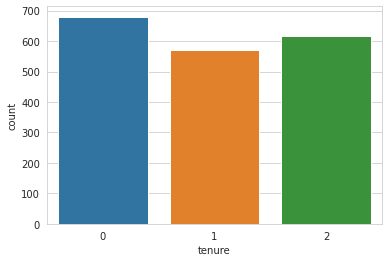

In [39]:
print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='tenure')
plt.show()

## Rewrite ML Pipeline for Modelling

In [40]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["feat_selection", SelectFromModel(model)])
  pipe.steps.append(["model", model])
  return pipe

## Load estimators for classification

In [41]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['tenure'],axis=1),
                                    df_clf['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Check if target is balanced

In [43]:
y_train.value_counts(normalize=True).to_frame().round(2)

,tenure
0,0.36
2,0.33
1,0.31


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [44]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [45]:
from sklearn.metrics import make_scorer, f1_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(f1_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [46]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.633333,0.65817,0.702929,0.0255069
3,GradientBoostingClassifier,0.630631,0.652244,0.691983,0.0223306
0,XGBClassifier,0.559671,0.593476,0.62069,0.0256591
1,DecisionTreeClassifier,0.528634,0.570731,0.627615,0.0326084
4,ExtraTreesClassifier,0.511628,0.553961,0.589744,0.0267486
2,RandomForestClassifier,0.514286,0.551839,0.60262,0.0303015


### Do extensive search on most suitable model to find best hyperparameter configuration

Define models and parameters

In [48]:
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier":{
        'model__n_estimators': [50,100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
    }
}

Extensive GridSearch CV

In [49]:
from sklearn.metrics import make_scorer,  f1_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [50]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.645914,0.660355,0.685259,0.0141237,0.1,50
5,AdaBoostClassifier,0.648,0.65899,0.685259,0.0139766,0.01,300
1,AdaBoostClassifier,0.639344,0.65809,0.688,0.0170438,0.1,100
2,AdaBoostClassifier,0.639344,0.653516,0.688525,0.0182376,0.1,300
4,AdaBoostClassifier,0.637795,0.653186,0.685259,0.0167588,0.01,100
3,AdaBoostClassifier,0.625899,0.645665,0.685259,0.0205223,0.01,50
8,AdaBoostClassifier,0.59306,0.626239,0.695652,0.0369149,0.001,300
7,AdaBoostClassifier,0.583333,0.613487,0.645963,0.0227189,0.001,100
6,AdaBoostClassifier,0.583333,0.612383,0.645963,0.023794,0.001,50



Check the best model

In [51]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [52]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 50}

Define the best clf pipeline

In [53]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelecti...
                                                     'InternetService',
                                                     'OnlineSecurity',
                                                     'OnlineBackup',
                                                   

## Assess feature importance

We can assess feature importane for this model with `.feature_importances_`

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


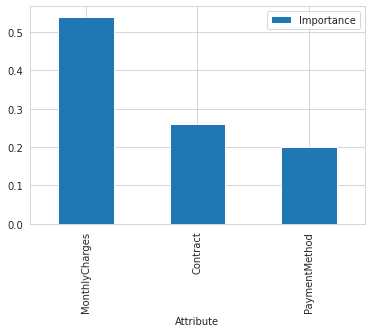

In [54]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
          'Importance': pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Attribute'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

In [55]:
best_features_clf = best_features
best_features_clf

['MonthlyCharges', 'Contract', 'PaymentMethod']

## Evaluate Classifier on Train and Test Sets

Custom Function

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")



def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

Creates a list that relates the classes and tenure interval

In [64]:
disc.binner_dict_['tenure']

[-inf, 4.0, 20.0, inf]

We can create manually

In [67]:
label_map = ['<4.0', '4.0 to 20.0','+20.0']
label_map

['<4.0', '4.0 to 20.0', '+20.0']

In [69]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                418                207           89
Prediction 4.0 to 20.0          91                151          103
Prediction +20.0                28                109          299


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.59      0.78      0.67       537
           1       0.44      0.32      0.37       467
           2       0.69      0.61      0.65       491

    accuracy                           0.58      1495
   macro avg       0.57      0.57      0.56      1495
weighted avg       0.57      0.58      0.57      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                113                 40           22
Prediction 4.0 to 20.0          24                 39           22
Prediction +20.0  

# Which pipeline to choose?

We fitted multiple pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold of 0.7 for R2 score, for train and test set.

The classifier was tuned on f1 score for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and can separate the opposite classes: class 0 (<4 months) and class 2 (+20 months).
* Class 1 (4 to 20 months) has weak performance. We will accept this limitation and will handle a prediction of class 1 as if it was a prediction of class 0.

# Refit pipeline with best features

## Split Train Test Set, only with best features

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['tenure'],axis=1),
                                    df_clf['tenure'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Subset Best Features

In [71]:
X_train = X_train.filter(best_features_clf)

X_test = X_test.filter(best_features_clf)
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 3) (1495,) 
* Test set: (374, 3) (374,)


Check how training data looks like now

In [ ]:
X_train.head(3)

## Rewrite Data Cleaning and Feature Engineering Pipeline

In [73]:
def PipelineDataCleaningAndFeatureEngineering():
  pipeline_base = Pipeline(
      [
      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['Contract', 'PaymentMethod']
                                                  )
      ),
       
    ]
  )

  return pipeline_base

## Rewrite Modelling Pipeline (removes feat_selection)

In [74]:
def PipelineOptimization(model):
  pipe = PipelineDataCleaningAndFeatureEngineering()
  pipe.steps.append(["scaler", StandardScaler()])
  pipe.steps.append(["model", model])
  return pipe


## Grid Search CV – Sklearn

* using most suitable model from last section and it best hyperparameter configuration

We are using the same model from the last GridCV search

In [75]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the last GridCV search

In [76]:
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 50}

You will need to type in manually, since the hyperparameter values has to be a list. The previous dictonary is not in this format

In [77]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.1],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.1],
  'model__n_estimators': [50]}}

GridSearch CV

In [78]:
from sklearn.metrics import make_scorer, f1_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [79]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.645914,0.662462,0.685259,0.0128518,0.1,50


Check the best model

In [80]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model

In [81]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1, 'model__n_estimators': 50}

Define the best clf pipeline

In [82]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Contract', 'PaymentMethod'])),
                ('scaler', StandardScaler()),
                ['model',
                 AdaBoostClassifier(learning_rate=0.1, random_state=0)]])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


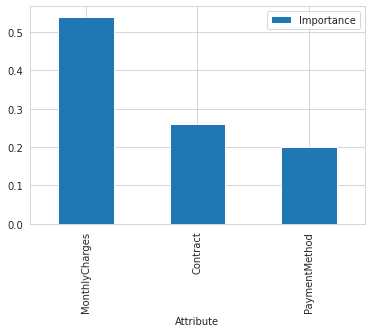

In [83]:
# after data cleaning and feat engine, the feature space changes
columns_after_data_cleaning_feat_eng = (PipelineDataCleaningAndFeatureEngineering()
                                        .fit_transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Attribute': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Attribute'].to_list()}")

df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.show()

## Evaluate Classifier on Train and Test Sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set : features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline (that includes Data Cleaning and Feat Eng pipeline)

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline.pkl")

## Dictionary mapping target levels to bins

Map for converting numerical variable to categorical variable

In [ ]:
labels_map

In [ ]:
joblib.dump(value=labels_map ,
            filename=f"{file_path}/labels_map.pkl")

## Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Attribute', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Attribute',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

## **Push** generated/new files from this Session to GitHub repo

Now you can push the files to the GitHub repo!!!

* Git status

In [ ]:
! git status

* Git commit

In [ ]:
CommitMsg = "added-files-predict-tenure"
! git add .
! git commit -m {CommitMsg}

* Git Push

In [ ]:
! git push origin main

Good job! Save the notebook in your repo.

Then, terminate the session (Runtime - Manage Sessions - Terminate)